# Importing Libraries & datasets

In [54]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [28]:
df = pd.read_excel("../final_df.xlsx")

# Time Series Analysis


## Hyperparameter Tuning 

### Checking Stationarity of the Data

In [30]:
def adfuller_test(series, series_name, signif=0.05):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= signif:
        print(f" => {series_name} is Stationary. (Reject the null hypothesis)")
    else:
        print(f" => {series_name} is Non-Stationary. (Fail to reject the null hypothesis)")

# Perform Dickey-Fuller test on the data
for i in list(["Quantity", "Clicks", "Impressions"]):
    print(f"ADF Test for {i}:")
    adfuller_test(df[i], i)
    print("-"*70)

ADF Test for Quantity:
ADF Statistic: -4.445717448758575
p-value: 0.00024615679644112006
Critical Values:
	1%: -3.4621857592784546
	5%: -2.875537986778846
	10%: -2.574231080806213
 => Quantity is Stationary. (Reject the null hypothesis)
----------------------------------------------------------------------
ADF Test for Clicks:
ADF Statistic: -0.8705717270828215
p-value: 0.797509057499528
Critical Values:
	1%: -3.4620315036789666
	5%: -2.8754705024827127
	10%: -2.5741950726860647
 => Clicks is Non-Stationary. (Fail to reject the null hypothesis)
----------------------------------------------------------------------
ADF Test for Impressions:
ADF Statistic: -5.6962061101258685
p-value: 7.863580125889645e-07
Critical Values:
	1%: -3.46172743446274
	5%: -2.8753374677799957
	10%: -2.574124089081557
 => Impressions is Stationary. (Reject the null hypothesis)
----------------------------------------------------------------------


<b><i>Data series is stationary for Quantity and Impressions attribute.

In [31]:
# Function to make a series stationary
def make_stationary(series):
    series_log = np.sqrt(series)
    series_diff = series_log.diff().dropna()
    return series_diff

df["Clicks_stationary"] = make_stationary(df["Clicks"])

<b><i>Making Clicks_stationary

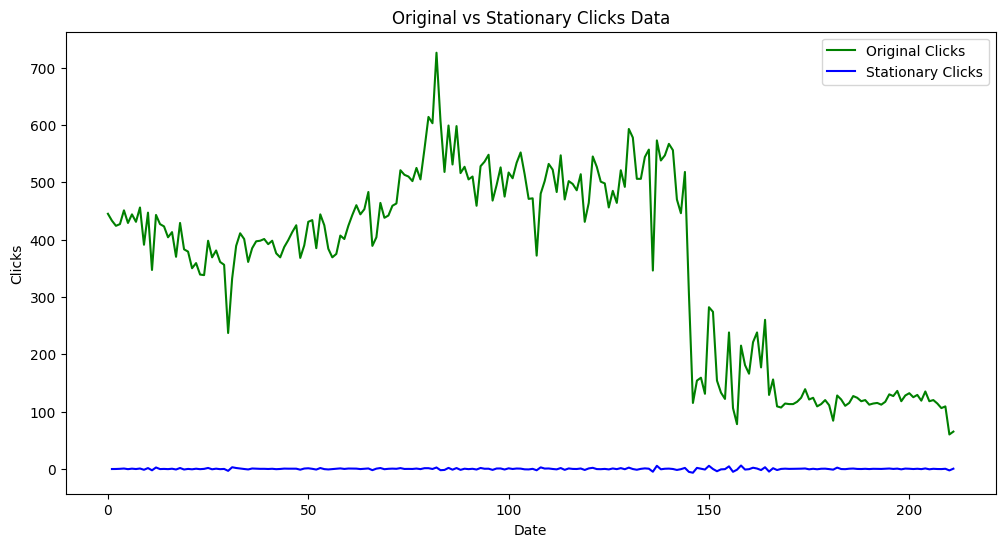

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Clicks'], label='Original Clicks', color='green')
plt.plot(df.index, df['Clicks_stationary'], label='Stationary Clicks', color='blue')
plt.title('Original vs Stationary Clicks Data')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.legend()
plt.show()

<b><i>Hence, Clicks_stationary is a stationary series.

### Plotting ACF and PACF plots

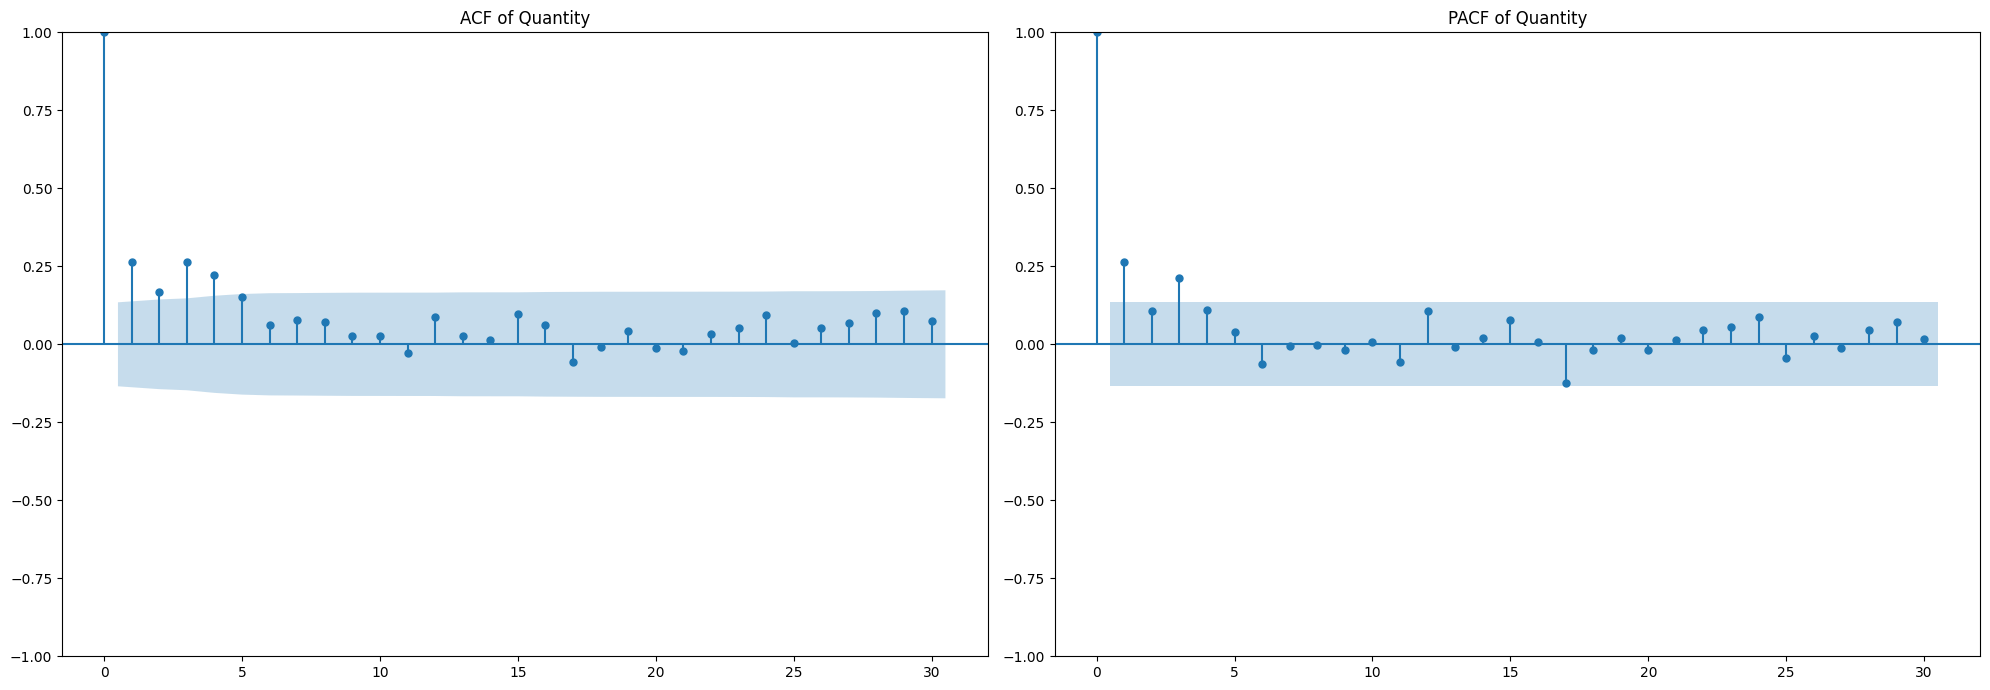

In [33]:
# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# ACF plot
plot_acf(df['Quantity'], lags=30, ax=ax1)
ax1.set_title('ACF of Quantity')

# PACF plot
plot_pacf(df['Quantity'], lags=30, ax=ax2)
ax2.set_title('PACF of Quantity')

plt.tight_layout()
plt.show()


### Determining Optimal Parameters

<i><b>Value of differencing is zero, d = 0.</b> (Since, data series for quantity is stationary)<p>
<i><b>And The value of p = 1 and q = 1 for Quantity.</b> (Since each plot have a single biggest spike)<p>

## Data Splitting

<table>
  <tr>
    <th>Data set</th>
    <th>percentage</th>
    <th>Num of days</th>
  </tr>
  <tr>
    <td>train set</td>
    <td>60 %</td>
    <td>127 days</td>
  </tr>
  <tr>
    <td>validation set</td>
    <td>20 %</td>
    <td>42 days</td>
  </tr>
  <tr>
    <td>test set</td>
    <td>20 %</td>
    <td>43 days</td>
  </tr>
</table>



In [34]:
# Calculate the split indices
train_size = int(0.6 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

# Split the df
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

print("Train Data Size:\t", len(train_df))
print("Validation Data Size:\t", len(val_df))
print("Test Data Size:\t\t", len(test_df))

Train Data Size:	 127
Validation Data Size:	 42
Test Data Size:		 43


## Modelling

#### <i>functions for plotting predictions of models</i>

In [35]:
warnings.filterwarnings("ignore")       # to ignore ny warnings while fitting the model

In [36]:
def plot_predictions_and_metrics(train_df, val_df, test_df, model, model_name='Model'):
    # Make predictions
    start_train = 0
    end_train = len(train_df) - 1
    predictions_train = model.predict(start=start_train, end=end_train)

    start_val = len(train_df)
    end_val = start_val + len(val_df) - 1
    predictions_val = model.predict(start=start_val, end=end_val)
    
    start_test = len(train_df) + len(val_df)
    end_test = start_test + len(test_df) - 1
    predictions_test = model.predict(start=start_test, end=end_test)

    # Plot predictions vs actuals for training, validation, and test sets
    plt.figure(figsize=(15, 7))
    plt.plot(train_df.index, train_df['Quantity'], label='Training Data')
    plt.plot(val_df.index, val_df['Quantity'], label='Validation Data')
    plt.plot(test_df.index, test_df['Quantity'], label='Test Data')
    plt.plot(train_df.index, predictions_train, label='Training Predictions', color='blue', linestyle='--')
    plt.plot(val_df.index, predictions_val, label='Validation Predictions', color='red', linestyle='--')
    plt.plot(test_df.index, predictions_test, label='Test Predictions', color='green', linestyle='--')
    plt.title(f'{model_name} - Training vs Validation vs Test')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

    # Calculate evaluation metrics
    def calculate_metrics(actual, predicted):
        mse = mean_squared_error(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        return mse, mae, mape.round(3)

    mse_val, mae_val, mape_val = calculate_metrics(val_df['Quantity'], predictions_val)
    mse_test, mae_test, mape_test = calculate_metrics(test_df['Quantity'], predictions_test)

    # Print evaluation metrics
    print(f'Validation Set Metrics for {model_name}:')
    print(f'MSE: {mse_val} \nMAE: {mae_val} \nMAPE: {mape_val}%')
    print(f'\nTest Set Metrics for {model_name}:')
    print(f'MSE: {mse_test} \nMAE: {mae_test} \nMAPE: {mape_test}%')
    

In [37]:
def plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, model, model_name):
    # Generate predictions for the validation set
    predictions_val = model.get_forecast(steps=len(val_df), exog=exog_val).predicted_mean

    # Generate predictions for the test set
    predictions_test = model.get_forecast(steps=len(test_df), exog=exog_test).predicted_mean

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(train_df.index, train_df['Quantity'], label='Train', color='blue')
    plt.plot(val_df.index, val_df['Quantity'], label='Validation', color='orange')
    plt.plot(test_df.index, test_df['Quantity'], label='Test', color='green')
    plt.plot(val_df.index, predictions_val, label='Validation Predictions', color='red')
    plt.plot(test_df.index, predictions_test, label='Test Predictions', color='purple')
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.show()

    def calculate_mape(actual_values, predicted_values):
        actual_values = np.array(actual_values)
        predicted_values = np.array(predicted_values)
        abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
        abs_percentage_error[np.isnan(abs_percentage_error)] = 0
        mape = np.mean(abs_percentage_error) * 100
        return mape 

    # Calculate metrics
    mse_val = mean_squared_error(val_df['Quantity'], predictions_val)
    mae_val = mean_absolute_error(val_df['Quantity'], predictions_val)
    mape_val = calculate_mape(val_df['Quantity'], predictions_val)

    mse_test = mean_squared_error(test_df['Quantity'], predictions_test)
    mae_test = mean_absolute_error(test_df['Quantity'], predictions_test)
    mape_test = calculate_mape(test_df['Quantity'], predictions_test)

    # Print metrics
    print(f'{model_name} Validation Set Metrics:')
    print(f'MSE: {mse_val}')
    print(f'MAE: {mae_val}')
    print(f'MAPE: {mape_val.round(3)}%')

    print(f'\n{model_name} Test Set Metrics:')
    print(f'MSE: {mse_test}')
    print(f'MAE: {mae_test}')
    print(f'MAPE: {mape_test.round(3)}%')

### AR Model

In [38]:
# fitting the model
AR_model = AutoReg(train_df['Quantity'], lags=1)            # AR(1) Model
AR_result = AR_model.fit()          

# Print model summary
# print(AR_result.summary())      

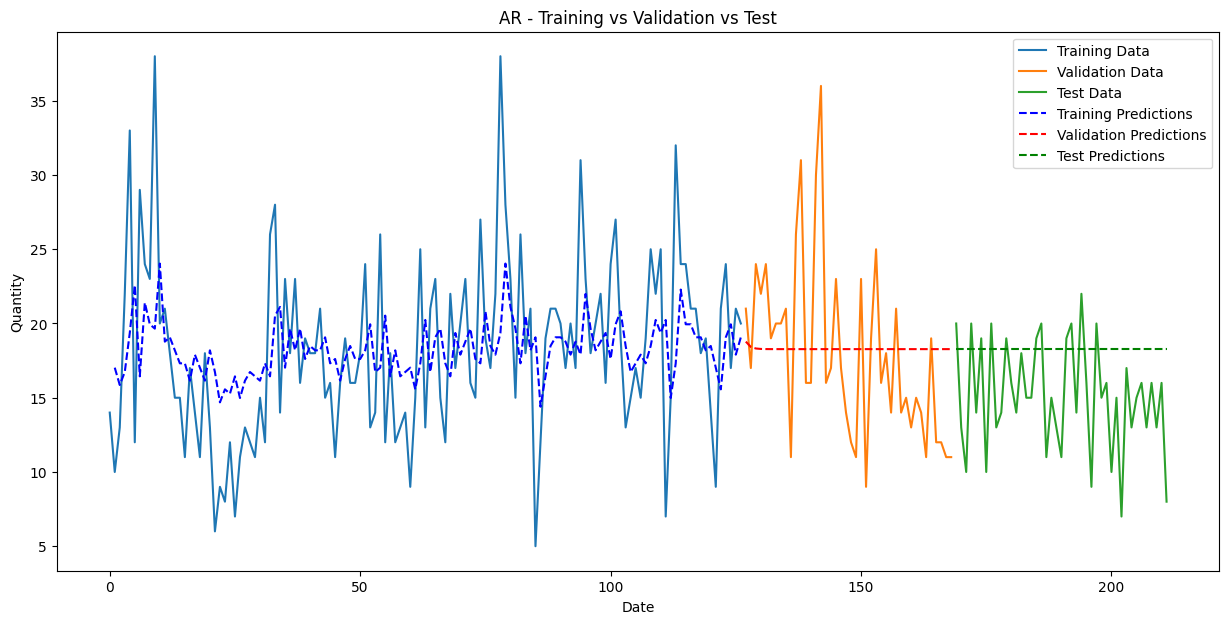

Validation Set Metrics for AR:
MSE: 35.390861987384206 
MAE: 4.79104632790376 
MAPE: 29.412%

Test Set Metrics for AR:
MSE: 23.27032762215448 
MAE: 3.970837259954068 
MAPE: 33.668%


In [39]:
plot_predictions_and_metrics(train_df, val_df, test_df, AR_result, model_name='AR')

### MA Model

In [40]:
# Define and fit MA model
MA_model = ARIMA(train_df['Quantity'], order=(0, 0, 1))     # MA(1) model
MA_result = MA_model.fit()

# Print model summary
# print(MA_result.summary())

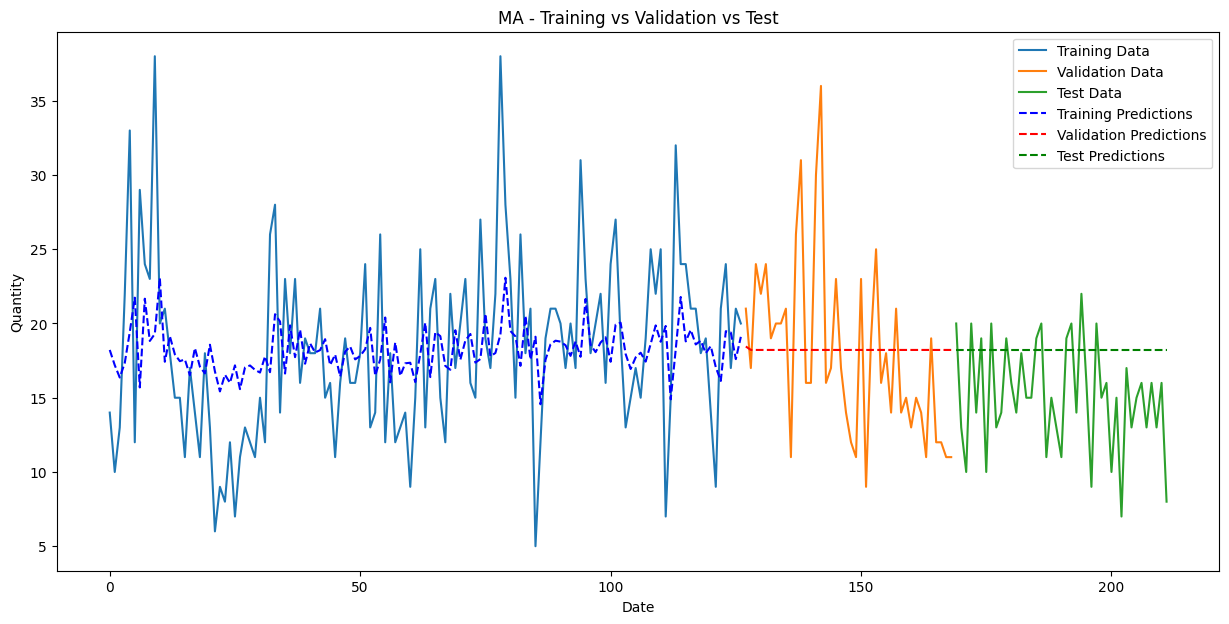

Validation Set Metrics for MA:
MSE: 35.39928979101906 
MAE: 4.787626155146834 
MAPE: 29.297%

Test Set Metrics for MA:
MSE: 22.92531257030517 
MAE: 3.9441194044408863 
MAPE: 33.421%


In [41]:
plot_predictions_and_metrics(train_df, val_df, test_df, MA_result, model_name='MA')

### ARMA Model

In [42]:
# fitting the model
ARMA_model = ARIMA(train_df['Quantity'], order=(1, 0, 1))           # ARMA(1, 1) Model   
ARMA_result = ARMA_model.fit()          

# Print model summary
# print(ARMA_result.summary())                       

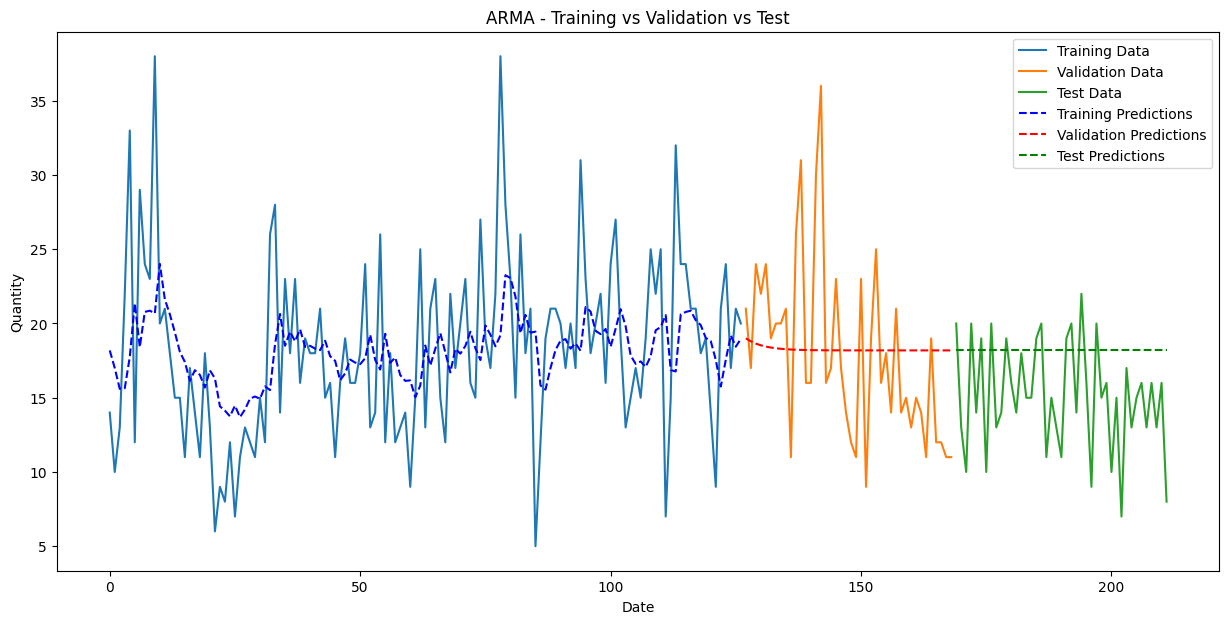

Validation Set Metrics for ARMA:
MSE: 35.05135718042404 
MAE: 4.746750557674151 
MAPE: 29.086%

Test Set Metrics for ARMA:
MSE: 22.73237289436732 
MAE: 3.9289722056512426 
MAPE: 33.281%


In [43]:
plot_predictions_and_metrics(train_df, val_df, test_df, ARMA_result, model_name='ARMA')

### ARIMA Model

In [44]:
# fitting the model
ARIMA_model = ARIMA(train_df['Quantity'], order=(1, 0, 1))           # ARIMA(1, 0, 1) Model   
ARIMA_result = ARIMA_model.fit()          

# Print model summary
# print(ARIMA_result.summary())                       

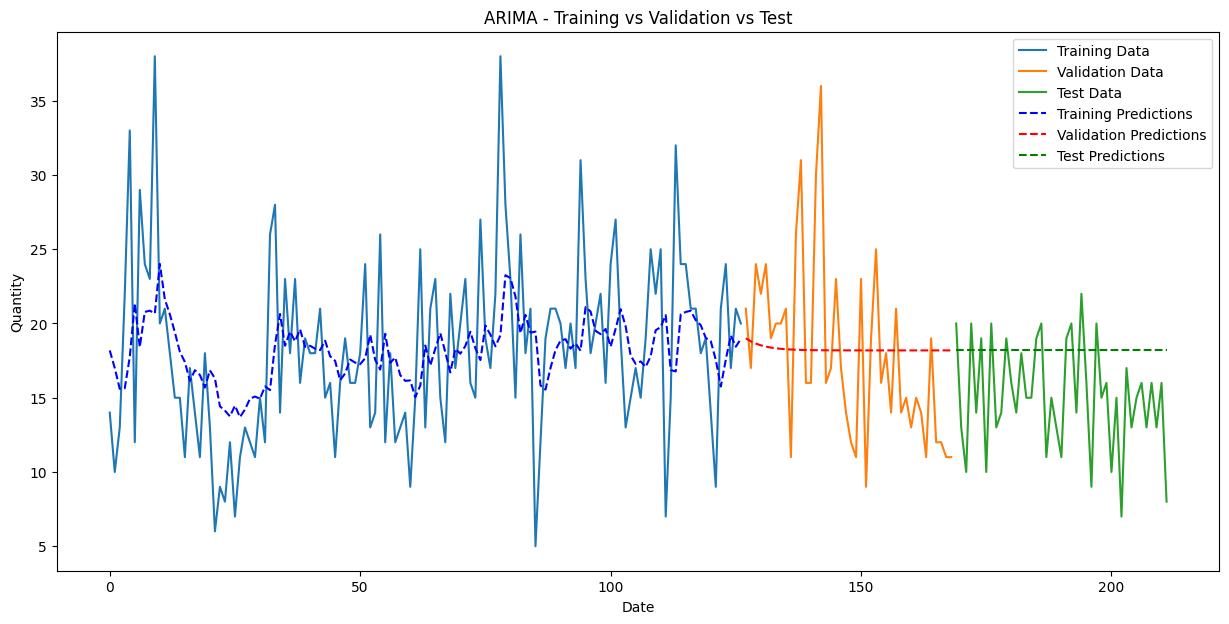

Validation Set Metrics for ARIMA:
MSE: 35.05135718042404 
MAE: 4.746750557674151 
MAPE: 29.086%

Test Set Metrics for ARIMA:
MSE: 22.73237289436732 
MAE: 3.9289722056512426 
MAPE: 33.281%


In [45]:
plot_predictions_and_metrics(train_df, val_df, test_df, ARIMA_result, model_name='ARIMA')

### SARIMA Model

* <i>`Seasonality` taken as 6 because
    * potential pattern every 6 month
    * gives least error as compared to 7 or 12 month

In [46]:
# Define and fit SARIMA model
sarima_model = SARIMAX(train_df['Quantity'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 6))         # potential seasonal pattern every 6 months and 6 gives the least error
sarima_model = sarima_model.fit()

# Print model summary
# print(result_sarima.summary())

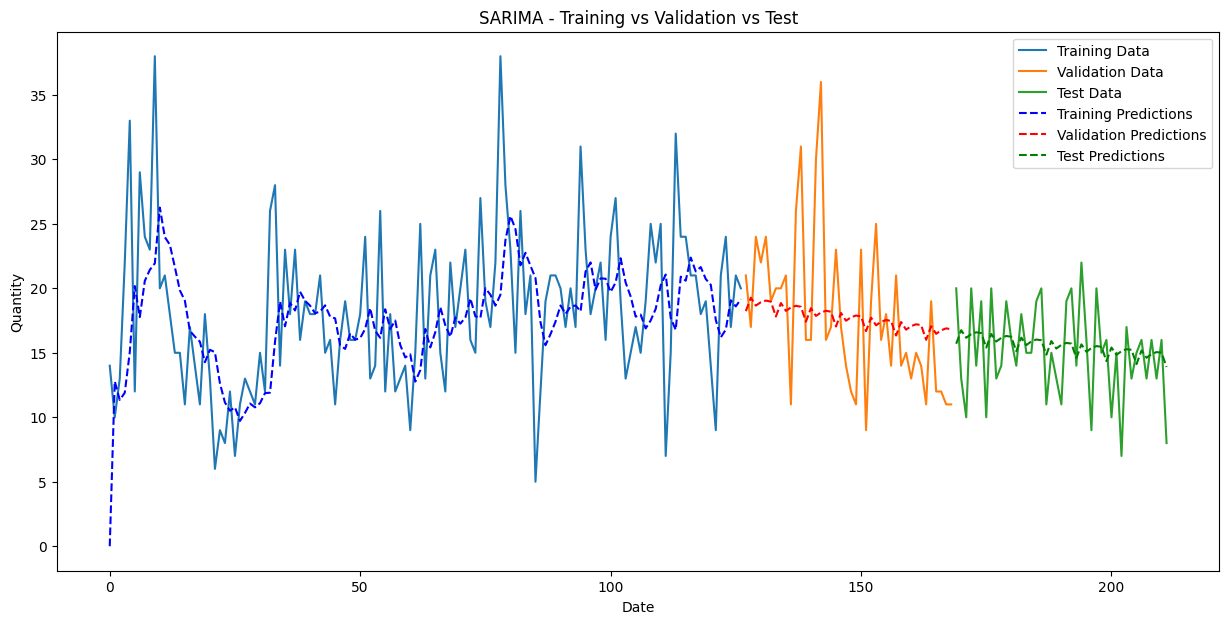

Validation Set Metrics for SARIMA:
MSE: 31.822343609006193 
MAE: 4.448567268146645 
MAPE: 26.227%

Test Set Metrics for SARIMA:
MSE: 11.946178533386432 
MAE: 2.842762243190187 
MAPE: 22.315%


In [47]:
plot_predictions_and_metrics(train_df, val_df, test_df, sarima_model, model_name='SARIMA')

### ARIMAX Model

In [48]:
# Drop NaN values for modeling
train_df = train_df.dropna(subset=['Clicks_stationary'])
val_df = val_df.dropna(subset=['Clicks_stationary'])
test_df = test_df.dropna(subset=['Clicks_stationary'])

* Using `Impressions` and `Clicks_stationary` together as `exogenous variable` gives the <u>least error</u>.
* Meanwhile, Taking them separately gives <u>high error<u>.

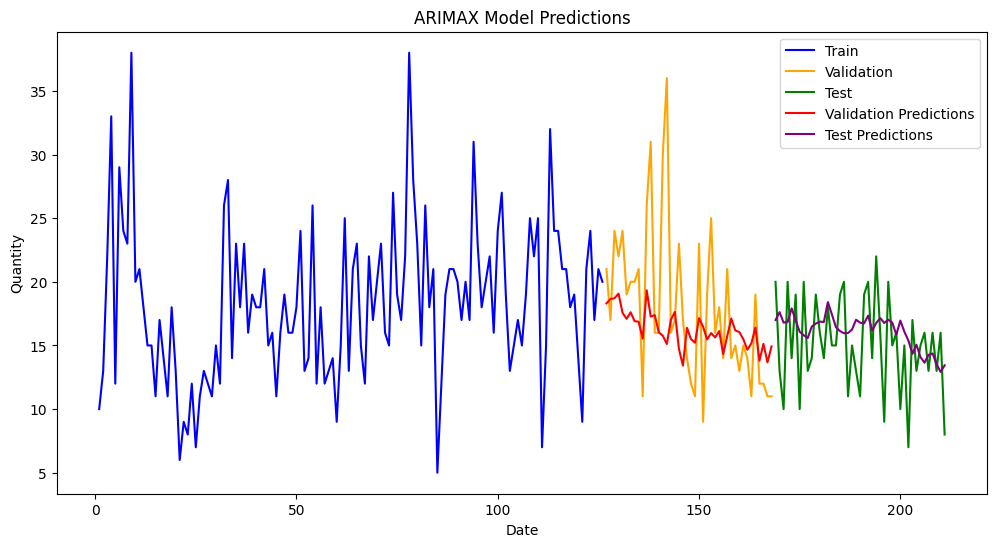

ARIMAX Validation Set Metrics:
MSE: 34.12351836103625
MAE: 4.1931957104006985
MAPE: 22.296%

ARIMAX Test Set Metrics:
MSE: 13.83956543464899
MAE: 3.1295384092829055
MAPE: 25.027%


In [49]:
# Define exogenous variables for train, validation, and test sets
exog_train = train_df[['Clicks_stationary', 'Impressions']]
exog_val = val_df[['Clicks_stationary', 'Impressions']]
exog_test = test_df[['Clicks_stationary', 'Impressions']]

# Fit the ARIMAX model
arimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1)).fit()

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, arimax_model, 'ARIMAX')

### SARIMAX Model

* Using `Impressions` and `Clicks_stationary` together as `exogenous variable` gives the <u>least error</u>.
* Meanwhile, Taking them separately gives <u>high error</u>.
* `Seasonality` is taken 12 for lowest error.

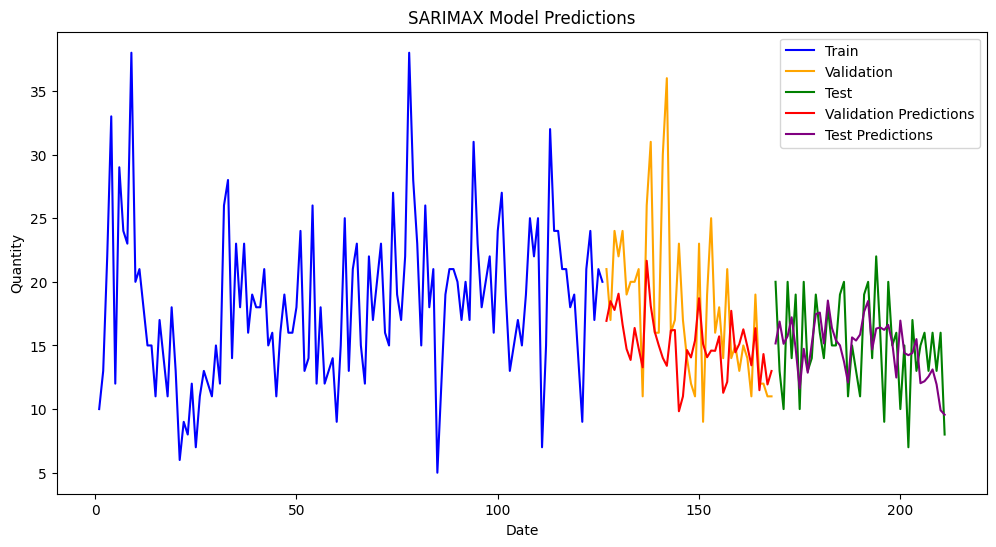

SARIMAX Validation Set Metrics:
MSE: 41.55460416519864
MAE: 4.503744563992768
MAPE: 22.522%

SARIMAX Test Set Metrics:
MSE: 12.491696279219278
MAE: 2.8409982352938226
MAPE: 21.022%


In [50]:
exog_train = train_df[['Clicks_stationary', 'Impressions']]
exog_val = val_df[['Clicks_stationary', 'Impressions']]
exog_test = test_df[['Clicks_stationary', 'Impressions']]

# Fit the SARIMAX model
sarimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()              #  12 month seasonality gives least error

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, sarimax_model, 'SARIMAX')

### ARIMAX / SARIMAX - with AdStock

#### <i> finding best decay factor

In [51]:
def adstock_transform(series, decay_factor):
    transformed_values = [0]  # Start with 0 adstock for the first observation
    for i in range(1, len(series)):
        transformed_values.append(series[i] + decay_factor * transformed_values[i - 1])
    transformed_series = pd.Series(transformed_values, index=series.index)
    return transformed_series
def find_best_decay_factor(df, decay_factors):
    best_decay_factor = None
    best_total_mape = np.inf

    for decay_factor in decay_factors:
        df['Clicks_adstock'] = adstock_transform(df['Clicks'], decay_factor)

        # Calculate the split indices
        train_size = int(0.6 * len(df))
        val_size = int(0.2 * len(df))
        test_size = len(df) - train_size - val_size

        # Split the df
        train_df = df.iloc[:train_size]
        val_df = df.iloc[train_size:train_size + val_size]
        test_df = df.iloc[train_size + val_size:]

        # Train SARIMAX model
        model = SARIMAX(train_df['Quantity'], exog=train_df[['Clicks_adstock', 'Impressions']], order=(1, 0, 1))
        sarimax_model = model.fit(disp=False)

        # Forecasting on validation and test sets
        forecast_val = sarimax_model.get_forecast(steps=len(val_df), exog=val_df[['Clicks_adstock', 'Impressions']]).predicted_mean
        forecast_test = sarimax_model.get_forecast(steps=len(test_df), exog=test_df[['Clicks_adstock', 'Impressions']]).predicted_mean

        def calculate_mape(actual_values, predicted_values):
            actual_values = np.array(actual_values)
            predicted_values = np.array(predicted_values)
            abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
            abs_percentage_error[np.isnan(abs_percentage_error)] = 0
            mape = np.mean(abs_percentage_error) * 100
            return mape 
    
        # Calculate MAPE
        mape_val = calculate_mape(val_df['Quantity'], forecast_val)
        mape_test = calculate_mape(test_df['Quantity'], forecast_test)
        total_mape = mape_val + mape_test

        # Check if current decay factor is better
        if total_mape < best_total_mape:
            best_total_mape = total_mape
            best_decay_factor = decay_factor

        # Print MAPE values
        print(f'Decay Factor: {decay_factor:.3f}, Validation MAPE: {mape_val:.3f}, Test MAPE: {mape_test:.3f}, Total MAPE: {total_mape:.3f}')

    return best_decay_factor

# Initial grid search for decay factor
decay_factors = np.linspace(0.9, 1.0, 10)
best_decay_factor = find_best_decay_factor(df, decay_factors)

# Refine search to three decimal places
for i in range(2, 4):  # Increasing the range for finer granularity
    lower_bound = best_decay_factor - 10**-i
    upper_bound = best_decay_factor + 10**-i
    decay_factors = np.linspace(lower_bound, upper_bound, 10)
    best_decay_factor = find_best_decay_factor(df, decay_factors)

# Use the best decay factor found
print(f'Best Decay Factor: {best_decay_factor:.3f}')


Decay Factor: 0.900, Validation MAPE: 22.743, Test MAPE: 45.614, Total MAPE: 68.358
Decay Factor: 0.911, Validation MAPE: 22.035, Test MAPE: 44.959, Total MAPE: 66.993
Decay Factor: 0.922, Validation MAPE: 21.161, Test MAPE: 43.163, Total MAPE: 64.324
Decay Factor: 0.933, Validation MAPE: 20.961, Test MAPE: 41.061, Total MAPE: 62.022
Decay Factor: 0.944, Validation MAPE: 21.893, Test MAPE: 38.029, Total MAPE: 59.921
Decay Factor: 0.956, Validation MAPE: 23.735, Test MAPE: 33.728, Total MAPE: 57.463
Decay Factor: 0.967, Validation MAPE: 27.226, Test MAPE: 28.123, Total MAPE: 55.349
Decay Factor: 0.978, Validation MAPE: 32.602, Test MAPE: 22.670, Total MAPE: 55.273
Decay Factor: 0.989, Validation MAPE: 41.675, Test MAPE: 30.622, Total MAPE: 72.297
Decay Factor: 1.000, Validation MAPE: 65.833, Test MAPE: 99.869, Total MAPE: 165.702
Decay Factor: 0.968, Validation MAPE: 24.964, Test MAPE: 30.408, Total MAPE: 55.371
Decay Factor: 0.970, Validation MAPE: 28.618, Test MAPE: 26.354, Total MAPE

<i>best decay factor found is 0.973

#### <i>Modelling

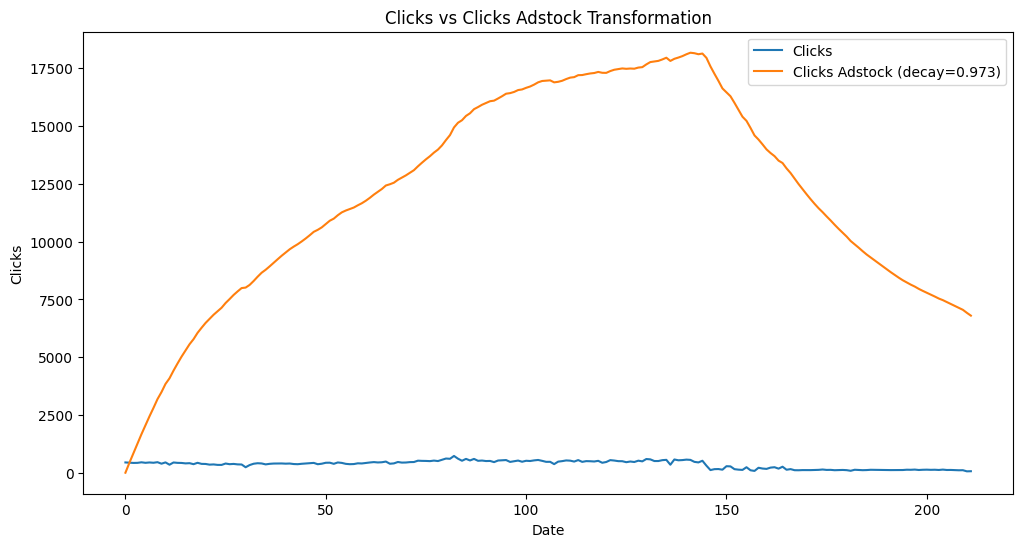

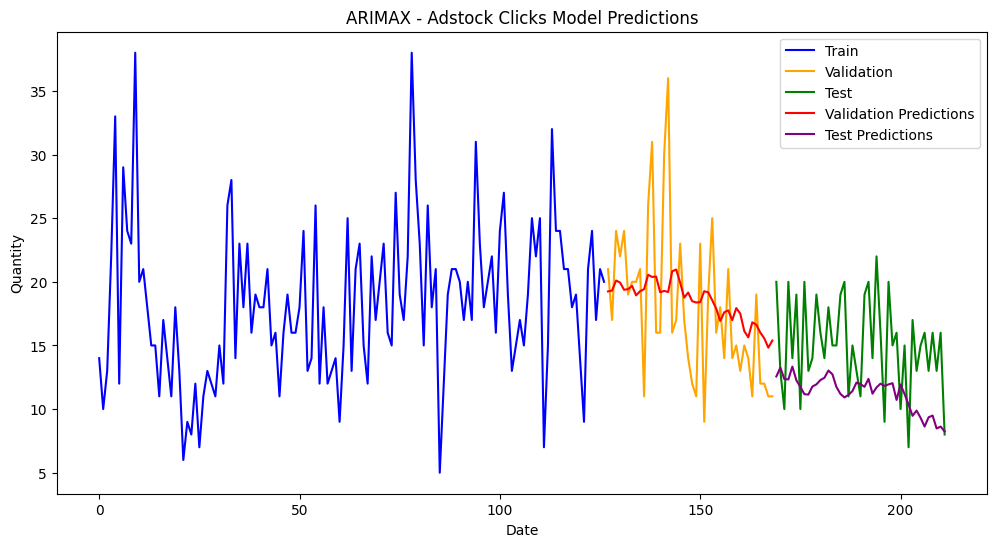

ARIMAX - Adstock Clicks Validation Set Metrics:
MSE: 28.765405522025606
MAE: 4.258532459141807
MAPE: 26.15%

ARIMAX - Adstock Clicks Test Set Metrics:
MSE: 27.511882066803057
MAE: 4.447944040355851
MAPE: 27.586%


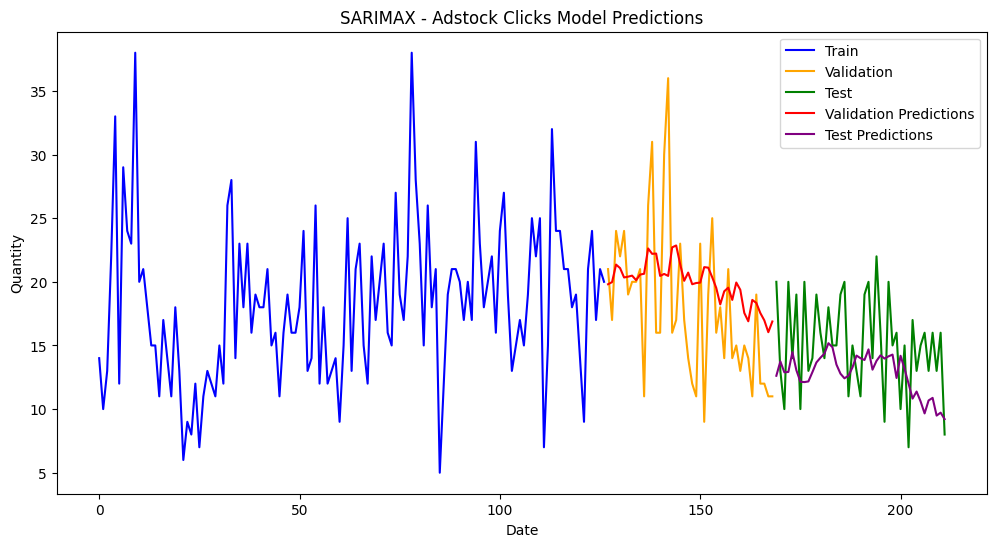

SARIMAX - Adstock Clicks Validation Set Metrics:
MSE: 32.86117278654616
MAE: 4.653257930336601
MAPE: 30.703%

SARIMAX - Adstock Clicks Test Set Metrics:
MSE: 18.646537839506554
MAE: 3.5904783511865817
MAPE: 23.586%


In [52]:
decay_factor = 0.973

df['Clicks_adstock'] = adstock_transform(df['Clicks'], decay_factor)

# Plotting both original and adstock-transformed series
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Clicks'], label='Clicks')
plt.plot(df.index, df['Clicks_adstock'], label=f'Clicks Adstock (decay={decay_factor})')
plt.xlabel('Date')
plt.ylabel('Clicks')
plt.legend()
plt.title('Clicks vs Clicks Adstock Transformation')
plt.show()

# Calculate the split indices
train_size = int(0.6 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

# Split the df
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

# model
exog_train = train_df[['Clicks_adstock', 'Impressions']]
exog_val = val_df[['Clicks_adstock', 'Impressions']]
exog_test = test_df[['Clicks_adstock', 'Impressions']]

# Fit the ARIMAX model
arimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1)).fit()              

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, arimax_model, 'ARIMAX - Adstock Clicks')

# Fit the SARIMAX model 
sarimax_model = SARIMAX(train_df['Quantity'], exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()              #  12 month seasonality gives least error

# Call the function to plot predictions and calculate metrics
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, sarimax_model, 'SARIMAX - Adstock Clicks')

* <i>Models (ARIMAX & SARIMAX) where `Clicks_stationary` was used, performed better than those which used `Clicks_adstock`.
    * `Clicks_stationary` used differencing 
    * `Clicks_adstock` used adstock-transform

### COMPARISON OF MODELS

<style>
  .red-text { color: red; }
  .yellow-text { color: yellow; }
  .green-text { color: green; }
</style>
<span class="red-text"><b>Total MAPE > 50</b></span><br>
<span class="yellow-text"><b>50 > Total MAPE > 45</b></span><br>
<span class="green-text"><b>Total MAPE < 45</b></span>



<table style="width:100%; border-collapse: collapse; border: 1px solid #ddd; font-size: 14px;">
  <thead>
    <tr>
      <th style="padding: 10px; text-align: left; font-size: 16px;">Set</th>
      <th style="padding: 10px; text-align: left; font-size: 16px;">Metric / Model</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">AR</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">MA</th>
      <th style="padding: 0px; text-align: center; font-size: 16px;">ARMA / ARIMA</th>
      <th style="padding: 0px; text-align: center; font-size: 16px;">ARIMAX - Clicks_stationary</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">SARIMA</th>
      <th style="padding: 0px; text-align: center; font-size: 16px;">SARIMAX - Clicks_stationary</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="3" style="padding: 10px;"><b style="font-size: 18px;">Validation</b></td>
      <td style="padding: 10px;">MSE</td>
      <td style="padding: 10px; text-align: center;">35.3909</td>
      <td style="padding: 10px; text-align: center;">35.3993</td>
      <td style="padding: 10px; text-align: center;">35.0514</td>
      <td style="padding: 10px; text-align: center;">34.1235</td>
      <td style="padding: 10px; text-align: center;">31.8223</td>
      <td style="padding: 10px; text-align: center;">41.5546</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAE</td>
      <td style="padding: 10px; text-align: center;">4.7910</td>
      <td style="padding: 10px; text-align: center;">4.7876</td>
      <td style="padding: 10px; text-align: center;">4.7468</td>
      <td style="padding: 10px; text-align: center;">4.1932</td>
      <td style="padding: 10px; text-align: center;">4.4486</td>
      <td style="padding: 10px; text-align: center;">4.5037</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAPE</td>
      <td style="padding: 10px; text-align: center;color:red;">29.412%</td>
      <td style="padding: 10px; text-align: center;color:red;">29.297%</td>
      <td style="padding: 10px; text-align: center;color:red;">29.086%</td>
      <td style="padding: 10px; text-align: center;color: yellow;">25.024%</td>
      <td style="padding: 10px; text-align: center;color: yellow;">26.227%</td>
      <td style="padding: 10px; text-align: center; color: green;"><i><b>22.522%</i></td>
    </tr>
    <tr>
      <td rowspan="3" style="padding: 10px;"><b style="font-size: 18px;">Test set</b></td>
      <td style="padding: 10px;">MSE</td>
      <td style="padding: 10px; text-align: center;">23.2703</td>
      <td style="padding: 10px; text-align: center;">22.9253</td>
      <td style="padding: 10px; text-align: center;">22.7324</td>
      <td style="padding: 10px; text-align: center;">13.8396</td>
      <td style="padding: 10px; text-align: center;">11.9462</td>
      <td style="padding: 10px; text-align: center;">12.4917</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAE</td>
      <td style="padding: 10px; text-align: center;">3.9708</td>
      <td style="padding: 10px; text-align: center;">3.9441</td>
      <td style="padding: 10px; text-align: center;">3.9290</td>
      <td style="padding: 10px; text-align: center;">3.1295</td>
      <td style="padding: 10px; text-align: center;">2.8428</td>
      <td style="padding: 10px; text-align: center;">2.8410</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAPE</td>
      <td style="padding: 10px; text-align: center;color: red;">33.668%</td>
      <td style="padding: 10px; text-align: center;color: red;">33.421%</td>
      <td style="padding: 10px; text-align: center;color: red;">33.281%</td>
      <td style="padding: 10px; text-align: center;color: yellow;">25.027%</td>
      <td style="padding: 10px; text-align: center;color: yellow;">22.315%</td>
      <td style="padding: 10px; text-align: center; color: green;"><i><b>21.022%</i></td>
    </tr>
  </tbody>
</table>


<table style="width:100%; border-collapse: collapse; border: 1px solid #ddd; font-size: 14px;">
  <thead>
    <tr>
      <th style="padding: 10px; text-align: left; font-size: 16px;">Set</th>
      <th style="padding: 10px; text-align: left; font-size: 16px;">Metric / Model</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">ARIMAX - Adstock Clicks</th>
      <th style="padding: 10px; text-align: center; font-size: 16px;">SARIMAX - Adstock Clicks</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="3" style="padding: 10px; vertical-align: middle; font-weight: bold;">Validation</td>
      <td style="padding: 10px;">MSE</td>
      <td style="padding: 10px; text-align: center;">28.7654</td>
      <td style="padding: 10px; text-align: center;">32.8612</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAE</td>
      <td style="padding: 10px; text-align: center;">4.2585</td>
      <td style="padding: 10px; text-align: center;">4.6533</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAPE</td>
      <td style="padding: 10px; text-align: center;color: red;">26.15%</td>
      <td style="padding: 10px; text-align: center;color: red;">30.703%</td>
    </tr>
    <tr>
      <td rowspan="3" style="padding: 10px; vertical-align: middle; font-weight: bold;">Test</td>
      <td style="padding: 10px;">MSE</td>
      <td style="padding: 10px; text-align: center;">27.5119</td>
      <td style="padding: 10px; text-align: center;">18.6465</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAE</td>
      <td style="padding: 10px; text-align: center;">4.4479</td>
      <td style="padding: 10px; text-align: center;">3.5905</td>
    </tr>
    <tr>
      <td style="padding: 10px;">MAPE</td>
      <td style="padding: 10px; text-align: center;color: red;">27.586%</td>
      <td style="padding: 10px; text-align: center;color: red;">23.586%</td>
    </tr>
  </tbody>
</table>
